# Data Preparation for the Models

In [1]:
import pandas as pd
import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from tqdm import tqdm

## Data Filtering and Preprocessing

We aim at predicting "is_recid". Some features in the dataset must be droped in order to remove features that might be directly linked to the target value, such as "is_violent_recid"

In [2]:
df = utils.read_data_files()
df = df.drop(df[df.is_recid == -1].index)

In [3]:
FEATURES = ['sex', 'age', 'age_cat', 'race',
            'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
            'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
            'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 
            'score_text', 'screening_date',
            'v_decile_score', 'v_score_text',
            'event']

TARGET = ['is_recid']

In [4]:
# Label encode categorical columns
df_encoded = df[FEATURES + TARGET].copy()
label_encoders = {}

for column in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))
    label_encoders[column] = le  # Store the label encoder for each column

# Now all columns should be numeric
X = df_encoded.drop('is_recid', axis=1)
y = df_encoded['is_recid']

In [5]:
# Handle missing values if any
X.fillna(X.mean(), inplace=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Models

### Random Forest SK Learn

In [6]:
# Create and fit the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate the model's performance
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

In [7]:
rf_roc_auc

0.9688935929135997

## Performance Interpretability

### Permutation Importance

In [8]:
rf_accuracy_list = []
rf_roc_auc_list = []

for feature in tqdm(list(X.columns)):
    X_test_ = X_test.copy()
    # Shuffle the feature's values without preserving the index
    X_test_[feature] = X_test_[feature].sample(frac=1).to_numpy()
    rf_predictions = rf_model.predict(X_test_)
    rf_accuracy_list.append(accuracy_score(y_test, rf_predictions))
    rf_roc_auc_list.append(roc_auc_score(y_test, rf_model.predict_proba(X_test_)[:, 1]))


100%|██████████| 20/20 [00:01<00:00, 11.60it/s]


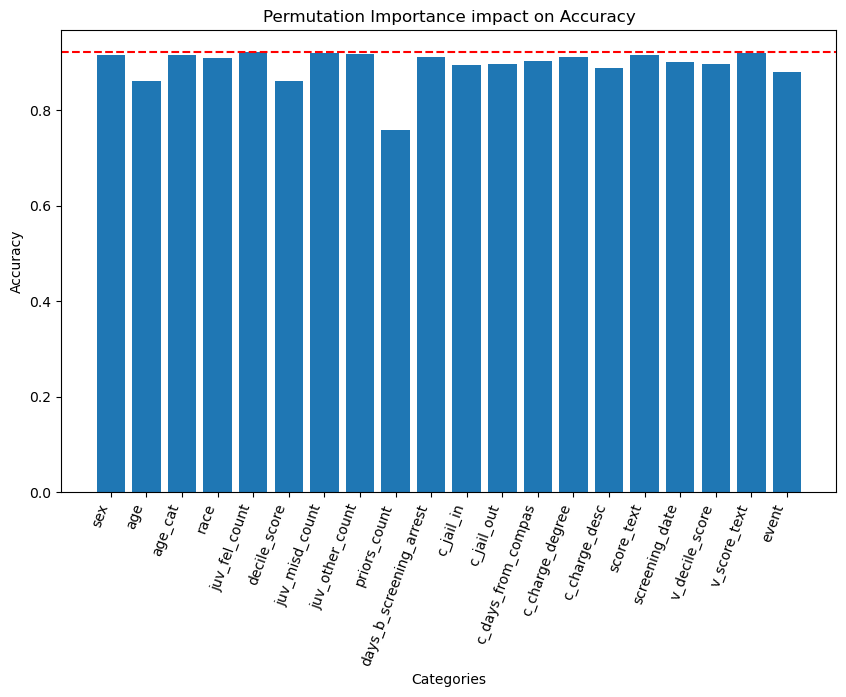

In [9]:
import matplotlib.pyplot as plt

fig, ax= plt.subplots(figsize=(10,6))
# Sample data for bar plot
categories = X.columns
values = rf_accuracy_list

# Create bar plot
ax.bar(categories, values)

# Draw a horizontal dashed line at y=40
ax.axhline(y=rf_accuracy, color='r', linestyle='--')

# Adding labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Accuracy')
ax.set_title('Permutation Importance impact on Accuracy')
plt.xticks(rotation=70, ha='right');
# Display the plot
plt.show()


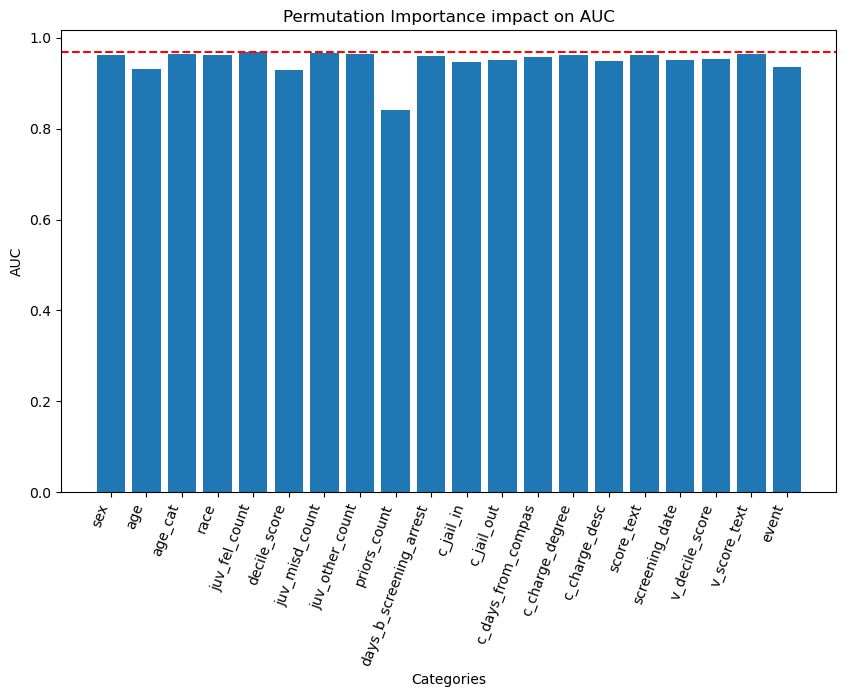

In [10]:
import matplotlib.pyplot as plt

fig, ax= plt.subplots(figsize=(10,6))
# Sample data for bar plot
categories = X.columns
values = rf_roc_auc_list

# Create bar plot
ax.bar(categories, values)

# Draw a horizontal dashed line at y=40
ax.axhline(y=rf_roc_auc, color='r', linestyle='--')

# Adding labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('AUC')
ax.set_title('Permutation Importance impact on AUC')
plt.xticks(rotation=70, ha='right');
# Display the plot
plt.show()


### XPER

In [11]:
from XPER.compute.Performance import ModelPerformance
from XPER.viz.Visualisation import visualizationClass as viz

In [14]:
len(df_encoded)

17496

In [15]:
df_encoded_ = df_encoded.sample(frac=.01)

X = df_encoded_.drop('is_recid', axis=1)
y = df_encoded_['is_recid']
# Handle missing values if any
X.fillna(X.mean(), inplace=True)

In [16]:
len(X)

175

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [18]:
# Define the evaluation metric(s) to be used
XPER = ModelPerformance(X_train, y_train, X_test, y_test, rf_model)

# Evaluate the model performance using the specified metric(s)
PM = XPER.evaluate(["AUC"])

# Print the performance metrics
print("Performance Metrics: ", round(PM, 3))

Performance Metrics:  1.0


In [19]:
# Option 1 - Kernel True
# Calculate XPER values for the model's performance
XPER_values = XPER.calculate_XPER_values(["AUC"])

Performing Computation:   0%|          | 0/1 [00:00<?, ?it/s]

2088


Performing Computation: 100%|██████████| 1/1 [10:15<00:00, 615.99s/it]


In [72]:


labels = list(X.columns)

In [73]:
viz.bar_plot(XPER_values=XPER_values, X_test=pd.DataFrame(X_test), labels=labels, p=6,percentage=True)

NameError: name 'XPER_values' is not defined